<a href="https://colab.research.google.com/github/tymor22/tm-vec/blob/master/google_colabs/Embed_sequences_using_TM_Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes:
1. In order to use TM-Vec and DeepBlast, you need to install TM-Vec, DeepBlast, and the huggingface transformers library. 
2. You will also need to download the ProtT5-XL-UniRef50 encoder (large language model that TM-Vec and DeepBlast uses), the trained TM-Vec model, and the trained DeepBlast model. As the ProtT5-XL-UniRef50 encoder is very large (~11.3GB), unless you have the necessary RAM on your GPU (at least more than the model), you may have to use a CPU runtime on Google Colab.
3. This notebook demonstrates how TM-Vec can be used to embed protein sequences.


<h3>Embedding protein sequences using a trained TM-Vec model</h3>

**1. Install the relevant libraries including tm-vec, the huggingface transformers library, and faiss**

In [ ]:
%pip install git+https://github.com/tymor22/tm-vec.git -q gwpy
%pip install -q SentencePiece transformers
%pip install faiss-cpu

  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<b>2. Load the relevant libraries<b>

In [ ]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import faiss
from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, encode
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns 

<b>3. Load the ProtT5-XL-UniRef50 tokenizer and model<b>

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.13.layer.0.layer_norm.weight', 'decoder.block.23.layer.0.SelfAttention.v.weight', 'decoder.block.21.layer.0.SelfAttention.q.weight', 'decoder.block.2.layer.1.EncDecAttention.o.weight', 'decoder.block.14.layer.2.layer_norm.weight', 'decoder.block.10.layer.0.SelfAttention.v.weight', 'decoder.block.7.layer.1.EncDecAttention.k.weight', 'decoder.block.6.layer.0.SelfAttention.k.weight', 'decoder.block.19.layer.0.SelfAttention.o.weight', 'decoder.block.18.layer.0.SelfAttention.k.weight', 'decoder.block.11.layer.1.EncDecAttention.q.weight', 'decoder.block.17.layer.1.layer_norm.weight', 'decoder.block.4.layer.0.SelfAttention.v.weight', 'decoder.block.17.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.0.SelfAttention.k.weight', 'decoder.block.3.layer.0.layer_norm.weight', 'decoder.block.9.layer.1.EncDecAttention

289

<b>3. Put the model onto your GPU if it is avilabile, switching the model to inference mode<b>

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
model = model.eval()

cpu


<b>4. Download a trained TM-Vec model, and its configuration file<b>

In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt -q gwpy
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json -q gwpy

<b> 5. Load a trained TM-Vec model<b>

In [ ]:
#TM-Vec model paths
tm_vec_model_cpnt = "tm_vec_cath_model.ckpt"
tm_vec_model_config = "tm_vec_cath_model_params.json"

#Load the TM-Vec model
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file tm_vec_cath_model.ckpt`


<b> 6. Load or paste some sequences that you would like to embed <b>

In [ ]:
#Here we download CATH-S35 data and sample
!wget https://users.flatironinstitute.org/thamamsy/public_www/cath-domain-seqs-S35-with-metadata.tsv  -q gwpy

In [ ]:
#Read in some sequences, sample a few, and put them in a list 
cath_data = pd.read_csv('cath-domain-seqs-S35-with-metadata.tsv', sep="\t")
cath_data_sample = cath_data.sample(50)
sequences = list(cath_data_sample['Sequence'].values)

In [ ]:
print("Example sequences:")
print(sequences[0:5])

Example sequences:
['GXAGAAHRLXEARXRRYDNKFARISDIDINQPESWRGRIFLTFDIDWAADFVLQDTIDLIEGAGVCATWFATHSTPLLENIRRNPLFELGVHPNFNPLLAGAHAEGVQEILDRTLELAPGCVSVRSHSLVQATSILNXFGERRLRYDCNILVPWDAGIVLQPWRHWTGDXVRVPYLWEDDVACLYDWEFDSTFDYWYQPDGINVLDFHPIHVYXNTESLRRYEDSREVHRNPVDLIRWRNTSAGSRTFLQSLLARNI', 'GTVNNELGYQLFRDFAENKGMFRPGATNIAIYNKQGEFVGTLDKAAMPDFSAVDSEIGVATLINPQYIASVKHNGGYTNVSFGDGENRYNIVDRNNAPSLDFHAPRLDKLVTEVAPTAVTAQGAVAGAYLDKERYPVFYRLGSGTQYIKDSNGQLTKMGGAYSWLTGGTVGSLSSYQNGEMISTSSGLVFDYKLNGAMPIYGEAGDSGSPLFAFDTVQNKWVLVGVLTAGNGAGGRGNNWAVIPLDFIGQKFNEDND', 'VEVGGGNDIDITTVDFIMSIGRGIGEETNVEQFRELADEAGATLCCSCPIADAGWLPKSRQVGQSGKVVGSCKLYVAMGISGSIQHMAGMKHVPTIIAVNTDPGASIFTIAKYGIVADIFDIEEELKAQLAA', 'MSGDTTLVDTVNASQSRQVFWDRDVYDLEIERIFEFRFYLDTIWEGGGAGLELLGPPMKSLLHCNWKVPVENFVGDGYHVGWTHAAALGQIGGPLAGLAGNRADIPFDDLGLQFTTRHGHGFGVIDNAAAAIHRKGDGWNKYLEDTRGEVRRKFGADRERLYVGHWNGAIFPNCSFLYGTNTFKIWHPRGPHEIEVWTYTMVPSDADPATKSAIQREATRTFGTAGTLESDDGENMSSATYVNRGVITRDGMMNSTMGVGYEGPHPVYPGIVGISFIGETSYRGFYRFWKEMIDAPDWASVKANDDNWDSVFTNRNFWNEK

<b> 7. Embed your sequences using TM-Vec <b> 



In [ ]:
encoded_sequences = encode(sequences, model_deep, model, tokenizer, device)

<b>8. Visualize your embedded sequences<b>

In [ ]:
sequence_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(encoded_sequences)

In [ ]:
#Make the relevant dataframe and add the metadata to it
sequence_tsne_df = pd.DataFrame(sequence_tsne)
sequence_tsne_df.columns = ["Dim1", "Dim2"]
sequence_tsne_df['Class'] = cath_data_sample['Class'].values
sequence_tsne_df['Architecture'] = cath_data_sample['Architecture'].values

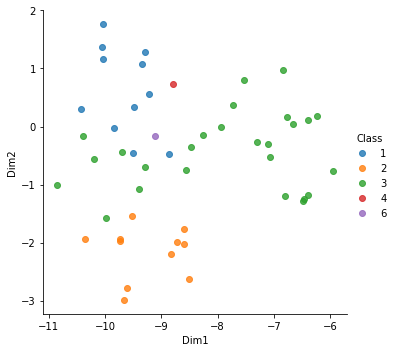

In [ ]:
#Visualize the TSNE, coloring by Class
sns.lmplot(x="Dim1", y="Dim2", data=sequence_tsne_df, hue="Class", fit_reg=False)